# 1. Dataset Preparation

## imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

In [7]:
import os
import glob

directory = '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/'
files = glob.glob(os.path.join(directory, '*.wav'))

num_samples = len(files)

class_counts = {"0": 0, "1": 0}

for f in files:
    filename = os.path.basename(f)
    
    if filename.startswith("0"):
        class_counts["0"] += 1
    elif filename.startswith("1"):
        class_counts["1"] += 1

print(f"Total samples: {num_samples}")
print(f"Class distribution: {class_counts}")


Total samples: 600
Class distribution: {'0': 300, '1': 300}


## Reading Audio Files


In [8]:
audio_files = glob.glob('/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/*.wav')
ipd.Audio(audio_files[1])

## print audio y , sample rate sr

In [9]:
y, sr = librosa.load(audio_files[1])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-0.00893145 -0.01208518 -0.01186652 -0.01093731 -0.00961248 -0.00909679
 -0.01019321 -0.01233972 -0.01435439 -0.015258  ]
shape y: (11679,)
sr: 22050


# 2. Preprocessing and Feature Extraction

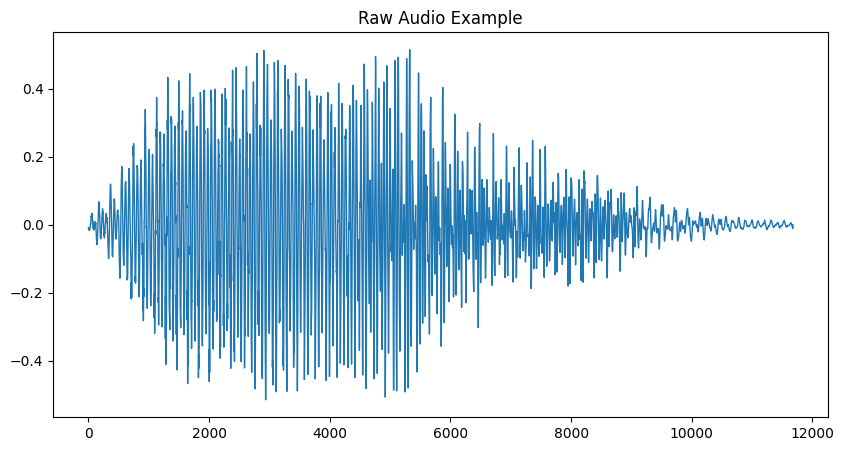

In [10]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example')
plt.show()

## Noise reduction

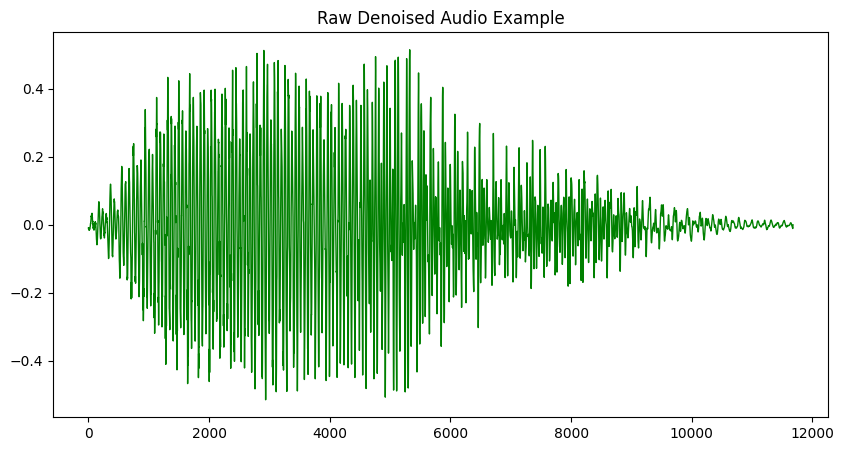

In [11]:
y_denoised = librosa.effects.preemphasis(y)
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Denoised Audio Example'
                  ,color='green')
plt.show()

## Silence removal

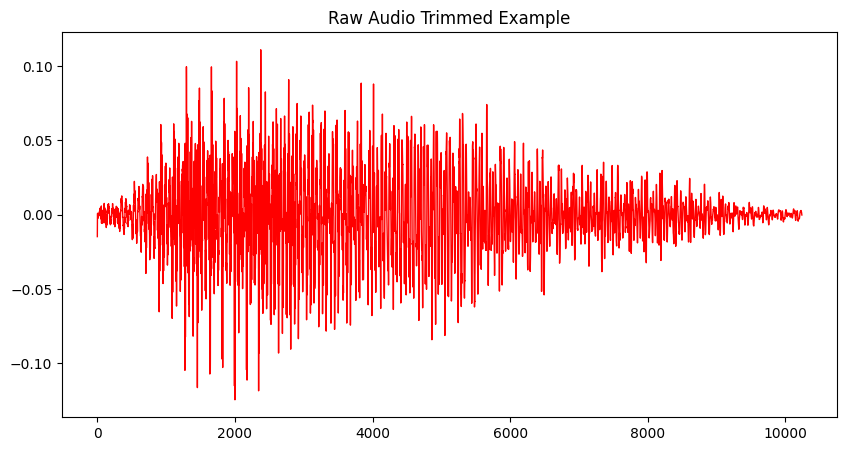

In [12]:
y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color='red')
plt.show()

## Normalization

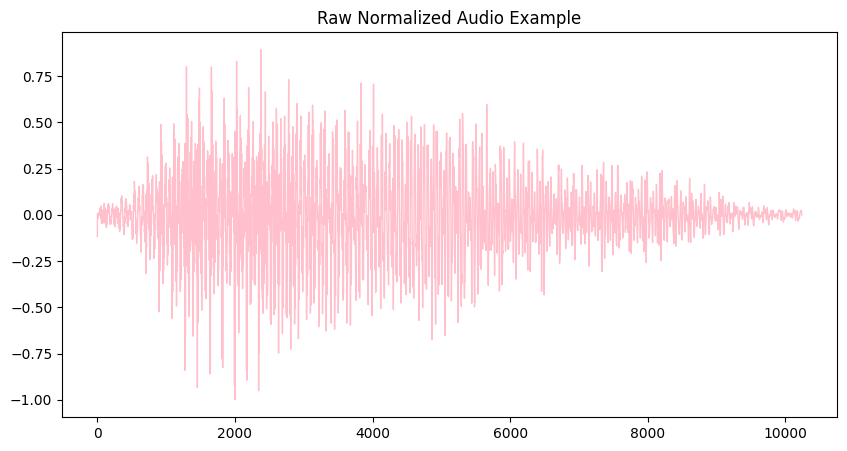

In [13]:
y_normalized = librosa.util.normalize(y_trimmed)
pd.Series(y_normalized).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Normalized Audio Example',
                 color='pink')
plt.show()

## data preprocessing

In [14]:
def preprocess_audio(audio_file):

    y, sr = librosa.load(audio_file, sr=None)

    y_denoised = librosa.effects.preemphasis(y)

    y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=30)

    y_normalized = librosa.util.normalize(y_trimmed)

    return y_normalized, sr

In [15]:
processed_audios = []

for audio_file in audio_files:
    y_processed, sr = preprocess_audio(audio_file)
    processed_audios.append((y_processed, sr))


## Feature Extraction

* MFCCs capture important speech patterns like how we hear.
* Spectral features (Centroid & Rolloff) show pitch and sharpness.
* ZCR measures how fast the sound changes (noisiness).



In [87]:
def extract_features_from_audio(y_processed, sr):

    mfccs = librosa.feature.mfcc(y=y_processed, sr=sr, n_mfcc=20)

    # Extract Spectral Features
    spectral_centroid = librosa.feature.spectral_centroid(y=y_processed, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y_processed, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y_processed)

    # Extract Chroma Features
    chroma = librosa.feature.chroma_stft(y=y_processed, sr=sr)

    # Extract Tonnetz
    tonnetz = librosa.feature.tonnetz(y=y_processed)

    # Extract RMS Energy
    rms = librosa.feature.rms(y=y_processed)

    # Create feature vector
    feature_vector = [
        np.mean(mfccs), np.std(mfccs),
        np.mean(spectral_centroid), np.std(spectral_centroid),
        np.mean(spectral_rolloff), np.std(spectral_rolloff),
        np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
        np.mean(chroma), np.std(chroma),
        np.mean(tonnetz), np.std(tonnetz),
        np.mean(rms), np.std(rms)
    ]

    return feature_vector



In [88]:
def extract_features_from_files(processed_audios):
    features = []

    for y_processed, sr in processed_audios:
        feature_vector = extract_features_from_audio(y_processed, sr)
        features.append(feature_vector)
    
    return features




In [89]:

def create_feature_dataframe(features):
    return pd.DataFrame(features, columns=[
        'Mean_MFCCs', 'Std_MFCCs',
        'Mean_Spectral_Centroid', 'Std_Spectral_Centroid',
        'Mean_Spectral_Rolloff', 'Std_Spectral_Rolloff',
        'Mean_Zero_Crossing_Rate', 'Std_Zero_Crossing_Rate',
        'Mean_Chroma', 'Std_Chroma',
        'Mean_Tonnetz', 'Std_Tonnetz',
        'Mean_RMS_Energy', 'Std_RMS_Energy'
    ])

In [90]:

def extract_labels_from_files(files):
    labels = []
    
    for f in files:
        filename = os.path.basename(f)
        print(f"Filename: {filename}")  # Debugging print
        if filename.startswith("0"):
            labels.append('0')
        elif filename.startswith("1"):
            labels.append('1')
    
    return labels

In [91]:

features = extract_features_from_files(processed_audios)
df_features = create_feature_dataframe(features)

labels = extract_labels_from_files(files)

print(df_features.head())
print(labels)


/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=522
  warnings.warn(
/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=261
  warnings.warn(
/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=131
  warnings.warn(
/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=66
  warnings.warn(
/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of leng

Filename: 1_nicolas_2.wav
Filename: 0_jackson_17.wav
Filename: 1_nicolas_23.wav
Filename: 0_nicolas_20.wav
Filename: 1_lucas_4.wav
Filename: 1_jackson_12.wav
Filename: 1_jackson_32.wav
Filename: 0_yweweler_11.wav
Filename: 0_jackson_44.wav
Filename: 0_theo_31.wav
Filename: 1_jackson_35.wav
Filename: 1_lucas_35.wav
Filename: 1_nicolas_18.wav
Filename: 0_jackson_49.wav
Filename: 1_lucas_30.wav
Filename: 0_jackson_5.wav
Filename: 1_nicolas_16.wav
Filename: 1_yweweler_5.wav
Filename: 0_yweweler_1.wav
Filename: 1_lucas_37.wav
Filename: 1_theo_9.wav
Filename: 0_george_23.wav
Filename: 0_yweweler_26.wav
Filename: 1_theo_24.wav
Filename: 0_yweweler_24.wav
Filename: 1_theo_8.wav
Filename: 1_yweweler_40.wav
Filename: 0_jackson_41.wav
Filename: 1_theo_39.wav
Filename: 0_yweweler_22.wav
Filename: 1_nicolas_8.wav
Filename: 1_lucas_9.wav
Filename: 1_nicolas_3.wav
Filename: 1_lucas_46.wav
Filename: 1_nicolas_24.wav
Filename: 1_theo_37.wav
Filename: 0_lucas_23.wav
Filename: 0_lucas_27.wav
Filename: 1_

/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1021
  warnings.warn(


In [95]:
df_features['Label']=labels

In [92]:
print(files)  # Check the list of files


['/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/1_nicolas_2.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/0_jackson_17.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/1_nicolas_23.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/0_nicolas_20.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/1_lucas_4.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/1_jackson_12.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/1_jackson_32.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/0_yweweler_11.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/0_jackson_44.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/0_theo_31.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/1_jackson_35.wav', '/home/rana-helal/PycharmProjects/FSDD-0-1-NB-LR-Bagging/records/1_lucas_35.wav',

In [96]:
print(df_features.head())


   Mean_MFCCs  Std_MFCCs  Mean_Spectral_Centroid  Std_Spectral_Centroid  \
0  -10.588798  17.288067             1875.121731             247.944566   
1  -18.515713  34.580456             1360.828003             411.093683   
2   -9.311885  15.448459             2229.639565             254.489646   
3  -11.954725  21.652281             2001.234444             456.408066   
4  -22.316895  57.025162             1516.680475             374.464237   

   Mean_Spectral_Rolloff  Std_Spectral_Rolloff  Mean_Zero_Crossing_Rate  \
0            3396.875000            180.426470                 0.320898   
1            2357.638889            691.949457                 0.154622   
2            3640.625000             84.901425                 0.480762   
3            3438.476562            288.585372                 0.355774   
4            2559.709821            208.690436                 0.329381   

   Std_Zero_Crossing_Rate  Mean_Chroma  Std_Chroma  Mean_Tonnetz  Std_Tonnetz  \
0                

In [97]:
df_features.to_csv('zero_one_audio_features.csv', index=False)


In [98]:
from sklearn.model_selection import train_test_split
X = df_features.drop('Label', axis=1).values.astype(float)
y = df_features['Label'].astype(int).values

from sklearn.decomposition import PCA
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)




# 3. Implement Naïve Bayes Classifier from Scratch

 *photos*

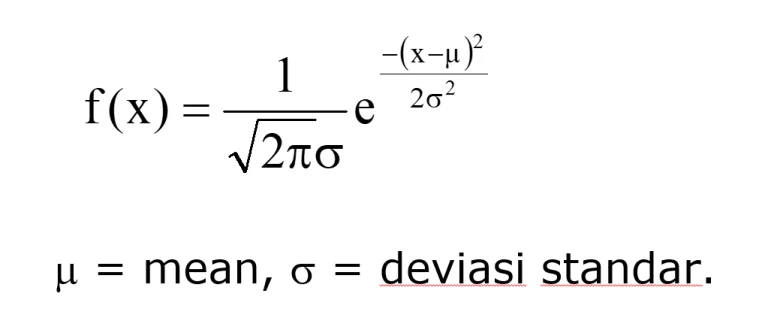

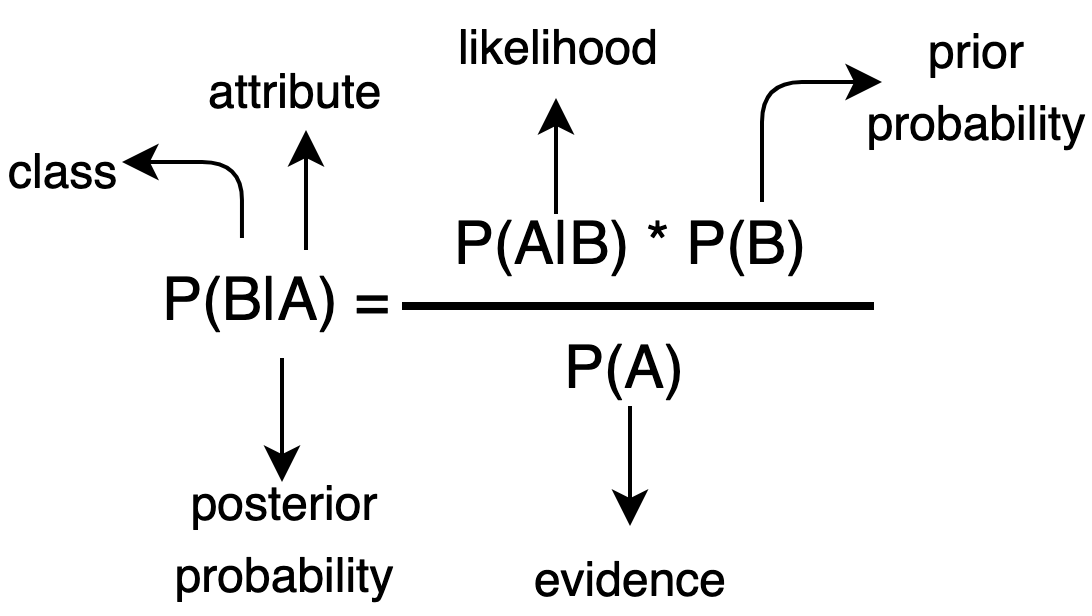

## Naïve Bayes from Scratch class

In [132]:
class GaussianNaiveBayes :
  def fit (self,X,y):
    #calculate mean and var for each feature
    self.classes=np.unique(y) #0, 1
    self.means={}
    self.variances={}
    self.priors={}

    for class1 in self.classes:
        X_class=X[y==class1]
        self.means[class1]=X_class.mean(axis=0) #go col by col
        self.variances[class1]=X_class.var(axis=0)
        self.priors[class1]=X_class.shape[0]/X.shape[0] # how many samples in class / how mant in total

  def gaussian (self,x,mean,var):
    eps = 1e-9  #to avoid dev by 0 if all values 00
    coef = 1.0 / np.sqrt(2.0 * np.pi * var + eps)
    exponent = np.exp(- ((x - mean) ** 2) / (2 * var + eps))
    result = coef * exponent
    return np.clip(result, 1e-10, None)  # Prevent log(0)

  def predict(self,X):
    predictions=[]

    for x in X :
      # loop for each data
      posteriors={}
      for class1 in self.classes :
        prior=np.log(self.priors[class1])
        likelihood=np.sum(np.log(self.gaussian(x, self.means[class1], self.variances[class1])))
        #calculate likelihood for each feature in the class
        #then take the log for each and sum all
        posteriors[class1]=prior+likelihood
      predictions.append(max(posteriors,key=posteriors.get))


    return predictions

  def evaluate(self, y_true, y_pred):
        accuracy = np.mean(y_true == y_pred)  # Accuracy = correct predictions / total predictions
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        f1_score = self.f1_score(precision, recall)
        return accuracy, precision, recall, f1_score

  def precision(self, y_true, y_pred):
        # Precision = TP / (TP + FP)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        return TP / (TP + FP) if TP + FP > 0 else 0

  def recall(self, y_true, y_pred):
        # Recall = TP / (TP + FN)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        return TP / (TP + FN) if TP + FN > 0 else 0

  def f1_score(self, precision, recall):
        # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
        return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0






In [133]:
model = GaussianNaiveBayes()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = np.array(y_pred).astype(int)

accuracy, precision, recall, f1_score = model.evaluate(y_test, y_pred)

print("Naïve Bayes from Scratch - Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Naïve Bayes from Scratch - Performance Metrics:
Accuracy: 0.8500
Precision: 0.8167
Recall: 0.8750
F1-Score: 0.8448


In [100]:
print("True values:", y_test)
y_pred = np.array(y_pred).astype(int)
print("Predicted values:", y_pred)



True values: [1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1
 1 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1
 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1
 1 1 1 1 0 0 1 0 1]
Predicted values: [1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1
 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1
 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 1
 1 1 1 1 0 0 0 0 1]


## Build-in Naïve Bayes

In [66]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_sklearn = clf.predict(X_test)

print(classification_report(y_test, y_pred_sklearn))


              precision    recall  f1-score   support

           0       0.89      0.84      0.86        64
           1       0.83      0.88      0.85        56

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120



## Logistic Regression (Individual Model)


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)

precision_lr = precision_score(y_test, y_pred_lr)

recall_lr = recall_score(y_test, y_pred_lr)

f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression - Performance Metrics:")

print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(f"Logistic Regression Precision: {precision_lr:.4f}")
print(f"Logistic Regression Recall: {recall_lr:.4f}")
print(f"Logistic Regression F1-Score: {f1_lr:.4f}")


Logistic Regression - Performance Metrics:
Logistic Regression Accuracy: 0.7917
Logistic Regression Precision: 0.7719
Logistic Regression Recall: 0.7857
Logistic Regression F1-Score: 0.7788


#4. Apply Bagging with Naïve Bayes and Logistic Regression

## Bagging Class

In [68]:
from sklearn.utils import resample
import numpy as np

class Bagging:
    def __init__(self, base_model, n_estimators=10):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            X_resampled, y_resampled = resample(X, y)
            model = self.base_model()
            model.fit(X_resampled, y_resampled)
            self.models.append(model)

    def predict(self, X):
        predictions = np.zeros((self.n_estimators, X.shape[0]))
        for i, model in enumerate(self.models):
            predictions[i, :] = model.predict(X)
        final_predictions = []
        for i in range(X.shape[0]):
            final_predictions.append(np.bincount(predictions[:, i].astype(int)).argmax())
        return np.array(final_predictions)

    def evaluate(self, y_true, y_pred):
        accuracy = np.mean(y_true == y_pred)
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        f1_score = self.f1_score(precision, recall)
        return accuracy, precision, recall, f1_score

    def precision(self, y_true, y_pred):
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        return TP / (TP + FP) if TP + FP > 0 else 0

    def recall(self, y_true, y_pred):
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        return TP / (TP + FN) if TP + FN > 0 else 0

    def f1_score(self, precision, recall):
        return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0




## Example Usage for Naïve Bayes

In [69]:
bagging_nb = Bagging(base_model=GaussianNaiveBayes, n_estimators=10)
bagging_nb.fit(X_train, y_train)
y_pred_bagging = bagging_nb.predict(X_test)

accuracy, precision, recall, f1_score = bagging_nb.evaluate(y_test, y_pred_bagging)

print("Bagging Naïve Bayes Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Bagging Naïve Bayes Performance Metrics:
Accuracy: 0.8750
Precision: 0.8475
Recall: 0.8929
F1-Score: 0.8696


## Example Usage for Logistic Regression


In [70]:
from sklearn.linear_model import LogisticRegression

bagging_lr = Bagging(base_model=lambda: LogisticRegression(max_iter=1000), n_estimators=10)
bagging_lr.fit(X_train, y_train)
y_pred_bagging_lr = bagging_lr.predict(X_test)

accuracy, precision, recall, f1_score = bagging_lr.evaluate(y_test, y_pred_bagging_lr)

print("Bagging Logistic Regression Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Bagging Logistic Regression Performance Metrics:
Accuracy: 0.7750
Precision: 0.7544
Recall: 0.7679
F1-Score: 0.7611


# test 

In [134]:
import sounddevice as sd

import soundfile as sf 



def list_audio_devices():
    print("Available input devices:")
    for i, device in enumerate(sd.query_devices()):
        if device['max_input_channels'] > 0:
            print(f"{i}: {device['name']} - Input Channels: {device['max_input_channels']}")

list_audio_devices()  

Available input devices:
4: HDA Intel PCH: ALC289 Analog (hw:1,0) - Input Channels: 2
9: pipewire - Input Channels: 64
10: pulse - Input Channels: 32
11: default - Input Channels: 64


In [157]:
def record_audio(duration=3, sample_rate=44100, device_index=None, channels=1):
    try:
        print("Recording...")
        audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate,
                       channels=channels, device=device_index)
        
        sd.wait(1)  
        print("Recording finished!")
        
        file_path = "recorded_audio.wav"  # Save file name
        sf.write(file_path, audio, sample_rate)
        
        print(f"Audio saved to {file_path}")
        return file_path
    except Exception as e:
        print(f"Recording failed: {e}")
        return None




def record_and_predict(model, pca, duration=3, device_index=4, channels=1):
    try:
        device_info = sd.query_devices(device_index)
        sample_rate = int(device_info['default_samplerate'])
        print(f"Using sample rate: {sample_rate}")

        # Record audio and save it
        audio_path = record_audio(duration=duration, sample_rate=sample_rate,
                                  device_index=device_index, channels=channels)
        if audio_path is None:
            print("Recording failed.")
            return

        # Load audio for feature extraction
        y, sr = librosa.load(audio_path, sr=None)
        
        # Extract features
        features = extract_features_from_audio(y, sr)

        # Apply PCA
        features_pca = pca.transform([features])

        # Predict
        prediction = model.predict(features_pca)[0]
        print(f"Predicted label: {prediction}")

    except Exception as e:
        print(f"Failed to record and predict: {e}")


record_and_predict(model, pca) 

Using sample rate: 48000
Recording...
Recording finished!
Audio saved to recorded_audio.wav
Predicted label: 0


In [144]:
import sounddevice as sd
import soundfile as sf

audio_file = 'recorded_audio.wav'  #
audio, sample_rate = sf.read(audio_file)

# Play the audio
sd.play(audio, sample_rate)
sd.wait()
